## Train a model with Iris data using XGBoost algorithm
###  Model is trained with XGBoost installed in notebook instance
###  In the later examples, we will train using SageMaker's XGBoost algorithm

In [1]:
# Install xgboost in notebook instance.
#### Command to install xgboost
!pip install xgboost==1.2

     |████████████████████████████████| 148.9 MB 63 kB/s /s eta 0:00:01   |███████████████▊                | 73.2 MB 19.3 MB/s eta 0:00:04


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import xgboost as xgb

from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
column_list_file = 'iris_train_column_list.txt'
train_file = 'iris_train.csv'
validation_file = 'iris_validation.csv'

In [4]:
columns = ''
with open(column_list_file,'r') as f:
    columns = f.read().split(',')

In [5]:
columns

['encoded_class', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [6]:
# Encode Class Labels to integers
# Labeled Classes
labels=[0,1,2]
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
le = preprocessing.LabelEncoder()
le.fit(classes)

LabelEncoder()

In [7]:
# Specify the column names as the file does not have column header
df_train = pd.read_csv(train_file,names=columns)
df_validation = pd.read_csv(validation_file,names=columns)

In [8]:
df_train.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width
0,1,5.8,2.7,3.9,1.2
1,2,6.1,2.6,5.6,1.4
2,2,5.8,2.8,5.1,2.4
3,0,4.4,3.2,1.3,0.2
4,2,7.2,3.6,6.1,2.5


In [9]:
df_validation.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width
0,1,5.8,2.7,4.1,1.0
1,0,4.8,3.4,1.6,0.2
2,1,6.0,2.2,4.0,1.0
3,2,6.4,3.1,5.5,1.8
4,2,6.7,2.5,5.8,1.8


In [10]:
X_train = df_train.iloc[:,1:] # Features: 1st column onwards 
y_train = df_train.iloc[:,0].ravel() # Target: 0th column

X_validation = df_validation.iloc[:,1:]
y_validation = df_validation.iloc[:,0].ravel()

In [11]:
# Launch a classifier
# XGBoost Training Parameter Reference: 
#   https://xgboost.readthedocs.io/en/latest/parameter.html

classifier = xgb.XGBClassifier(objective="multi:softmax",
                               num_class=3,
                               n_estimators=100)

In [12]:
classifier

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax',
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [13]:
classifier.fit(X_train,
               y_train,
               eval_set = [(X_train, y_train), (X_validation, y_validation)],
               eval_metric=['mlogloss'],
               early_stopping_rounds=10)

# early_stopping_rounds - needs to be passed in as a hyperparameter in SageMaker XGBoost implementation
# "The model trains until the validation score stops improving. 
# Validation error needs to decrease at least every early_stopping_rounds to continue training.
# Amazon SageMaker hosting uses the best model for inference."

[0]	validation_0-mlogloss:0.73876	validation_1-mlogloss:0.74994
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:0.52787	validation_1-mlogloss:0.55401
[2]	validation_0-mlogloss:0.38960	validation_1-mlogloss:0.42612
[3]	validation_0-mlogloss:0.29429	validation_1-mlogloss:0.34328
[4]	validation_0-mlogloss:0.22736	validation_1-mlogloss:0.29000
[5]	validation_0-mlogloss:0.17920	validation_1-mlogloss:0.24961
[6]	validation_0-mlogloss:0.14403	validation_1-mlogloss:0.22234
[7]	validation_0-mlogloss:0.11664	validation_1-mlogloss:0.20338
[8]	validation_0-mlogloss:0.09668	validation_1-mlogloss:0.18999
[9]	validation_0-mlogloss:0.08128	validation_1-mlogloss:0.18190
[10]	validation_0-mlogloss:0.06783	validation_1-mlogloss:0.17996
[11]	validation_0-mlogloss:0.05794	validation_1-mlogloss:0.18029
[12]	validation_0-mlogloss:0.05011	validation_1-mlogloss:0.1830

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
eval_result = classifier.evals_result()

In [15]:
training_rounds = range(len(eval_result['validation_0']['mlogloss']))

In [16]:
print(training_rounds)

range(0, 20)


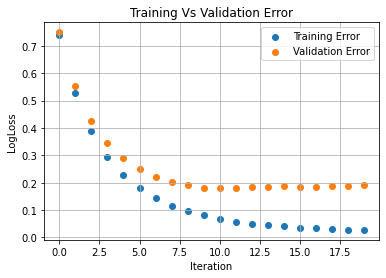

In [17]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['mlogloss'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['mlogloss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('LogLoss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

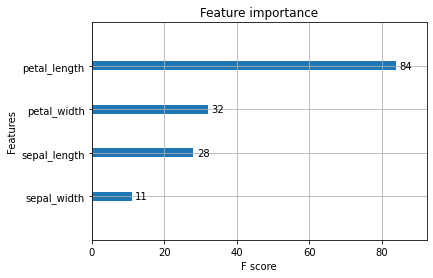

In [18]:
xgb.plot_importance(classifier)
plt.show()

In [19]:
df = pd.read_csv(validation_file,names=columns)

In [20]:
df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width
0,1,5.8,2.7,4.1,1.0
1,0,4.8,3.4,1.6,0.2
2,1,6.0,2.2,4.0,1.0
3,2,6.4,3.1,5.5,1.8
4,2,6.7,2.5,5.8,1.8


In [21]:
X_test = df.iloc[:,1:]
print(X_test[:5])

   sepal_length  sepal_width  petal_length  petal_width
0           5.8          2.7           4.1          1.0
1           4.8          3.4           1.6          0.2
2           6.0          2.2           4.0          1.0
3           6.4          3.1           5.5          1.8
4           6.7          2.5           5.8          1.8


In [22]:
result = classifier.predict(X_test)

In [23]:
result[:5]

array([1, 0, 1, 2, 2])

In [24]:
df['predicted_class'] = result #le.inverse_transform(result)

In [25]:
df.head()

,encoded_class,sepal_length,sepal_width,petal_length,petal_width,predicted_class
0,1,5.8,2.7,4.1,1.0,1
1,0,4.8,3.4,1.6,0.2,0
2,1,6.0,2.2,4.0,1.0,1
3,2,6.4,3.1,5.5,1.8,2
4,2,6.7,2.5,5.8,1.8,2


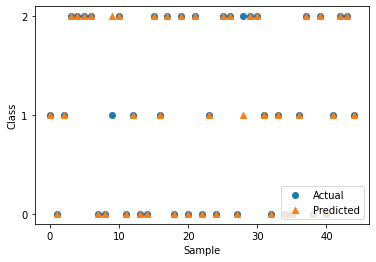

In [26]:
# Compare performance of Actual and Model 1 Prediction
plt.figure()
plt.scatter(df.index,df['encoded_class'],label='Actual')
plt.scatter(df.index,df['predicted_class'],label='Predicted',marker='^')
plt.legend(loc=4)
plt.yticks([0,1,2])
plt.xlabel('Sample')
plt.ylabel('Class')
plt.show()

<h2>Confusion Matrix</h2>
Confusion Matrix is a table that summarizes performance of classification model.<br><br>

In [27]:
# Reference: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [28]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(df['encoded_class'],
                              df['predicted_class'],labels=labels)

In [29]:
cnf_matrix

array([[16,  0,  0],
       [ 0, 10,  1],
       [ 0,  1, 17]])

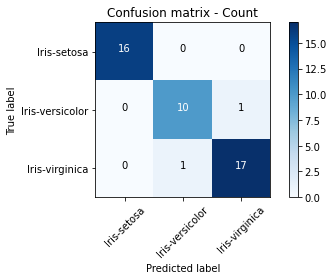

In [30]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count')

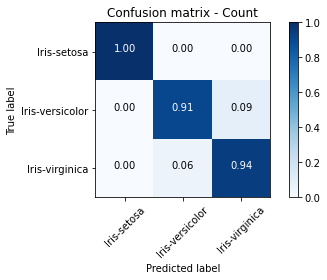

In [31]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix - Count',normalize=True)

In [32]:
print(classification_report(
    df['encoded_class'],
    df['predicted_class'],
    labels=labels,
    target_names=classes))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        16
Iris-versicolor       0.91      0.91      0.91        11
 Iris-virginica       0.94      0.94      0.94        18

       accuracy                           0.96        45
      macro avg       0.95      0.95      0.95        45
   weighted avg       0.96      0.96      0.96        45

